In [56]:
# Importando bibliotecas

!pip install -q kaggle
from google.colab import files
import pandas as pd
import numpy as np
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


In [4]:
 # Preparando para usar API do kaggle

 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedrojeronimo","key":"e01e602764cdd6488501411a5c2321e4"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Baixando dataset diretamente do kaggle

!kaggle datasets download -d iamsumat/spotify-top-2000s-mega-dataset

  0% 0.00/65.5k [00:00<?, ?B/s]
100% 65.5k/65.5k [00:00<00:00, 64.6MB/s]


In [8]:
# Descompactando arquivo zip contendo o dataset

!unzip spotify-top-2000s-mega-dataset.zip
!rm spotify-top-2000s-mega-dataset.zip
!ls

Archive:  spotify-top-2000s-mega-dataset.zip
  inflating: Spotify-2000.csv        
kaggle.json  sample_data  Spotify-2000.csv


In [112]:
data = pd.read_csv("Spotify-2000.csv")
print(data.head())

   Index                   Title             Artist            Top Genre  \
0      1                 Sunrise        Norah Jones      adult standards   
1      2             Black Night        Deep Purple           album rock   
2      3          Clint Eastwood           Gorillaz  alternative hip hop   
3      4           The Pretender       Foo Fighters    alternative metal   
4      5  Waitin' On A Sunny Day  Bruce Springsteen         classic rock   

   Year  Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  \
0  2004                     157      30            53            -14   
1  2000                     135      79            50            -11   
2  2001                     168      69            66             -9   
3  2007                     173      96            43             -4   
4  2002                     106      82            58             -5   

   Liveness  Valence Length (Duration)  Acousticness  Speechiness  Popularity  
0        11       68          

In [113]:
data = data.drop("Index", axis=1)

<Axes: >

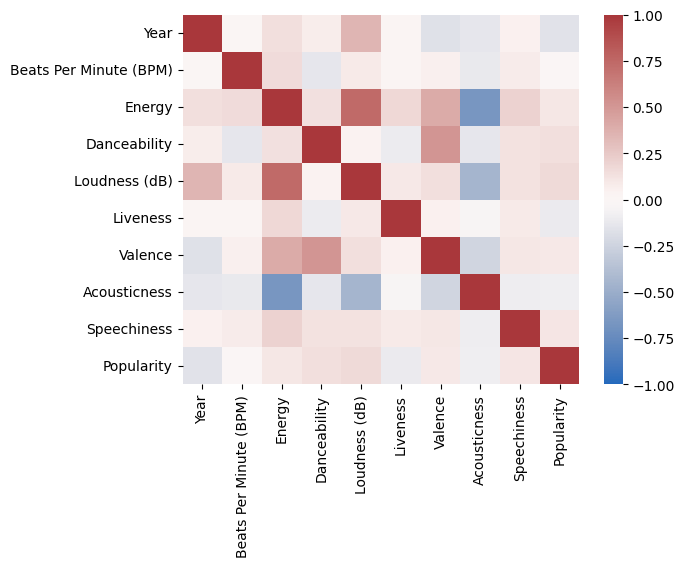

In [114]:
# Checando correlação entre as variáveis

sns.heatmap(data.corr(numeric_only=True), cmap="vlag", vmax=1,vmin=-1)

In [141]:
# Filtrando um dataframe temporário para possuir apenas as colunas numéricas

data2 = data[["Beats Per Minute (BPM)", "Loudness (dB)",
              "Liveness", "Valence", "Acousticness",
              "Speechiness"]]

# Instanciação da classe para normalização e normalização das colunas
scaler = MinMaxScaler()
data2_scaled = scaler.fit_transform(data2)


In [142]:
# Avaliar a variância de cada cluster para um número N de clusters, estimando um
# número de cluster mais otimizado

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data2_scaled)
    wcss.append(kmeans.inertia_)

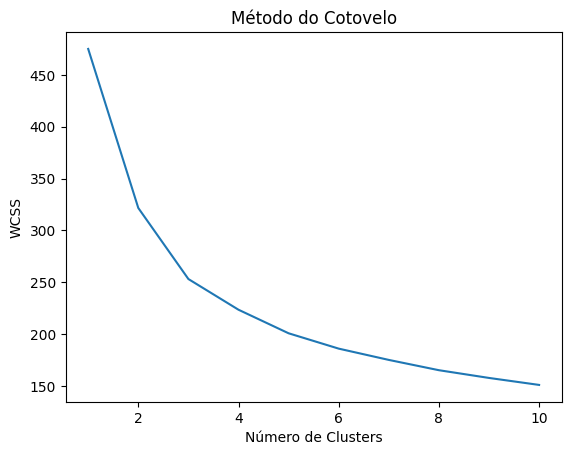

In [117]:
plt.plot(range(1, 11), wcss)
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

In [143]:
# Treinamento e predição do modelo K-means com o N observado no gráfico anterior
# onde a curva 'desacelera'

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
clusters = kmeans.fit_predict(data2_scaled)

In [144]:
# Avaliar a distância entre e intra-clusters
# Quanto mais próximo de 1, melhor

silhouette_avg = silhouette_score(data2_scaled, clusters)
print("A média da métrica de silhueta para os clusters é:", round(silhouette_avg,4))

A média da métrica de silhueta para os clusters é: 0.2702


In [145]:
# Atribuir os clusters preditos ao dataset inicial

data["Music Segments"] = clusters;data["Music Segments"].value_counts()

1    725
2    713
0    556
Name: Music Segments, dtype: int64

In [146]:
dicMap = {num:f'Cluster {num+1}' for num in range(n_clusters)};dicMap

{0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}

In [147]:
data = data.sort_values(by=["Music Segments"]);data.head()

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Music Segments
1968,Beautiful People,Melanie,classic uk pop,1969,129,44,54,-9,40,37,215,61,5,44,0
1810,The Family Tree,Venice,alternative rock,1999,127,10,34,-16,10,26,205,81,3,41,0
864,Mercedes Benz,Janis Joplin,blues rock,1971,87,11,70,-15,7,52,108,94,55,58,0
1617,Gaia,Valensia,classical rock,1993,174,33,38,-13,21,20,331,74,3,39,0
508,One Moment in Time,Whitney Houston,dance pop,2012,155,54,27,-7,10,33,285,49,3,54,0


In [148]:
# Renomeando os valores dos clusters para melhor entendimento
# Ex: 0 -> Cluster 1; 1 -> Cluster 2

data["Music Segments"] = data["Music Segments"].map(dicMap)

In [149]:
# Gráfico de dispersão 3D para visualização dos dados

import plotly.graph_objects as go
PLOT = go.Figure()
for i in list(data["Music Segments"].unique()):


    PLOT.add_trace(go.Scatter3d(x = data[data["Music Segments"]== i]['Beats Per Minute (BPM)'],
                                y = data[data["Music Segments"] == i]['Energy'],
                                z = data[data["Music Segments"] == i]['Danceability'],
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(i)))
PLOT.update_traces(hovertemplate='Beats Per Minute (BPM): %{x} <br>Energy: %{y} <br>Danceability: %{z}')


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Beats Per Minute (BPM)', titlefont_color = 'black'),
                                yaxis=dict(title = 'Energy', titlefont_color = 'black'),
                                zaxis=dict(title = 'Danceability', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))